# Project week 7

For the project this week, you are given a video of a ball rolling over a surface. Your job is now to detect the ball, track the position, velocity and acceleration using a Kalman filter, and finally draw the currently tracked position and predicted position of the ball in the images, while also printing the whole predicted state in either the image or the terminal.

The video "rolling_ball_result.mp4" shows what the end result could look like.

You have to make the Kalman filter yourselves, i.e. initialize the matrices and make a update and predict function. You are of course allowed to use numpy.

You can use the code below and fill in the missing parts.



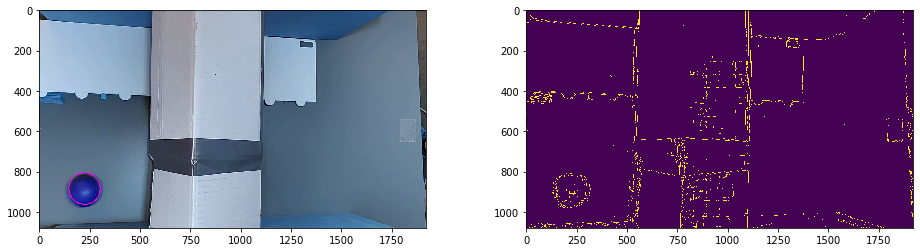

In [1]:
import cv2
#cv2 doesn't mean opencv2, but used to show using C++API instead of C API
import numpy as np
from matplotlib import pyplot as plt

#defines
low_H = 100
low_S = 43
low_V = 46
high_H = 124
high_S = 255
high_V = 255

cap = cv2.VideoCapture('rolling_ball.mp4')

#cap get
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
RGBor = cap.get(cv2.CAP_PROP_CONVERT_RGB)

#cap set
cap.set(cv2.CAP_PROP_POS_FRAMES,49)

#read frame
ret, frame = cap.read()

#frame modify
frame_HSV = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
frame_threshold = cv2.inRange(frame_HSV, (low_H, low_S, low_V), (high_H, high_S, high_V))
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
gray = gray * frame_threshold

#plt.figure(figsize = (16,4))
#plt.subplot(1,2,1)
#plt.imshow(gray)
#plt.subplot(1,2,2)
#plt.imshow(gray_after)

edge = cv2.Canny(gray, 25, 30)#25,30
circles = cv2.HoughCircles(edge, cv2.HOUGH_GRADIENT, 1, 2000, param1=30, param2=20, minRadius=65, maxRadius=80)

output = frame.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(output, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(output, center, radius, (255, 0, 255), 3)
        
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plt.imshow(output)
plt.subplot(1,2,2)
plt.imshow(edge)

In [2]:
center_predicted = (3,5)
center = np.array(center_predicted)
print(center)

[3 5]


In [6]:
import cv2
import numpy as np

#defines
low_H = 100
low_S = 43
low_V = 46
high_H = 124
high_S = 255
high_V = 255

def update(x, P, Z, H, R):
    ### Insert update function
    y = Z - H @ x
    S = H @ P @np.transpose(H) + R
    K = P @ np.transpose(H) @ np.linalg.pinv(S)
    x_update = x + K @ y
   #P_update = (I - K @ H) @ P
    P_update = P - K @ S @ np.transpose(K)
    return x_update, P_update

def predict(x, P, F, u):
    ### insert predict function
    x_predict = F @ x + u
    P_predict = F @ P @ np.transpose(F)
    return x_predict, P_predict
    
    
### Initialize Kalman filter ###
# The initial state (6x1).
x = np.zeros((6,1))

# The initial uncertainty (6x6).
P = np.identity(6) * 1000

# The external motion (6x1).
u = np.zeros((6,1))

# The transition matrix (6x6). 
#F = np.array([[1, 1, 0.5, 0, 0, 0],
#              [0, 1, 1, 0, 0, 0],
#              [0, 0, 1, 0, 0, 0],
#              [0, 0, 0, 1, 1, 0.5],
#              [0, 0, 0, 0, 1, 1],
#              [0, 0, 0, 0, 0, 1]]) 

#F = np.array([[1, 0.03333, 0.5*0.00111, 0, 0, 0],
#              [0, 1, 0.03333, 0, 0, 0],
#              [0, 0, 1, 0, 0, 0],
#              [0, 0, 0, 1, 0.03333, 0.5*0.00111],
#              [0, 0, 0, 0, 1, 0.03333],
#              [0, 0, 0, 0, 0, 1]], dtype=np.float64)


# still have problems with F
# when v = a*t, choosing a very small t can make it work
# but it doesn't fit the maths

F = np.array([[1, 0.03333, 0.0005, 0, 0, 0],
              [0, 1, 0.0005, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0.03333, 0.0005],
              [0, 0, 0, 0, 1, 0.0005],
              [0, 0, 0, 0, 0, 1]],dtype=np.float64) 


# The observation matrix (2x6).
H = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

# The measurement uncertainty.
R = np.array([[1, 0],
              [0, 1]])


# Load the video
cap = cv2.VideoCapture('rolling_ball_challenge.mp4')
FPS = cap.get(cv2.CAP_PROP_FPS)
print(FPS)
if not cap.isOpened():
    print("Cannot open video")
    exit()

center_predicted = (x[0],x[3])
# Looping through all the frames
while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    ### Detect the ball ###
    frame_HSV = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    frame_threshold = cv2.inRange(frame_HSV, (low_H, low_S, low_V), (high_H, high_S, high_V))
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray = gray * frame_threshold
    edge = cv2.Canny(gray, 25, 30)#25,30
    circles = cv2.HoughCircles(edge, cv2.HOUGH_GRADIENT, 1, 2000, param1=30, param2=20, minRadius=65, maxRadius=80)
    
    ### If the ball is found, update the Kalman filter ###
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # circle center
            center_detected = (i[0], i[1])
            # circle outline
            radius_detected = i[2]
            #cv2.circle(frame, center_detected, radius_detected, (255, 0, 255), 3)#pink
            Z = np.array([[center_detected[0]],
                          [center_detected[1]]])
            x, P = update(x, P, Z, H, R)
            center_update = (x[0],x[3])
            cv2.circle(frame, center_update, 80, (0, 255, 255), 5)#yellow
            cv2.putText(frame, 'updated', (center_update[0]-200,center_update[1]-80), cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,255),2,cv2.LINE_AA) 

    else:
        cv2.circle(frame, center_predicted, 80, (0, 0, 255), 5)#red  
        cv2.putText(frame, 'NOT FOUND', (center_predicted[0]-200,center_predicted[1]-80), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255),2,cv2.LINE_AA) 

    ### Predict the next state
    x, P = predict(x, P, F, u)
    center_predicted = (x[0], x[3])
    
    ### Draw the current tracked state and the predicted state on the image frame ###
    
    cv2.circle(frame, center_predicted, 80, (0, 255, 0), 3)#green
    cv2.putText(frame, 'predicted', (x[0]-200,x[3]+80), cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0),2,cv2.LINE_AA) 
    # Show the frame
    cv2.namedWindow('Frame',0)
    cv2.resizeWindow('Frame',800,500)
    cv2.imshow('Frame', frame)
    cv2.waitKey(50)
    
cap.release()
cv2.destroyAllWindows()

30.0


Try showing the video "rolling_ball_result.mp4" instead, to see what the end result could look like.

## Hints

The first part is to detect the ball. For this part you can look back to the exercises from week 2. More specifically the end of exercise 1. You may have to adjust some parameters in order to only detect the ball.

The next part is to make the Kalman filter. If you did the exercises from monday this week, you already have a suitable update and predict function. You will have to initialize all the different matrices, which we also did in the exercises, however this time we would like the state to include position, velocity and acceleration in both the x- and y-direction (6 states).

Start by defining your state **x** and uncertainty **P**. Then define a transition matrix **F** based on your state. When defining the state transition last time we used the equation for linear motion:

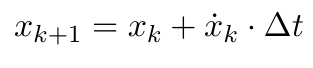

We used dt = 1 (delta t), for simplicity. You can do the same here. However, this time we also have the acceleration and therefore we use:

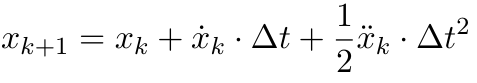

Finally, for a part of the video, the ball is behind something and can't be seen. Obviously we cant update our state here, because there is no measurement. So when there is no measurements available, you should only use the predict function and not the update function, to estimate the state.


# Challenge

If you can't get enough of tracking and Kalman filters, try extending your program, such that it can keep track of multiple balls at the same time. Use the video "rolling_ball_challenge.mp4" to test it. You can take advantage of the balls having different colours.

In [11]:
import cv2
#cv2 doesn't mean opencv2, but used to show using C++API instead of C API
import numpy as np
from matplotlib import pyplot as plt


mean_x = 3
mean_y = 4
p = np.array([[mean_x], [mean_y]])
print(p)

[[3]
 [4]]
